Train Hammerstein-, Wiener- and WienerHammerstein model on any type of data, with or without linear preprocessing.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from models import NeuralNetGlobalHammer, NeuralNetGlobalWiener, NeuralNetGlobalHammerWiener, cmplxMeanSquaredError
from util import load_signal_data, SIestimationLinear
from config import *

import pickle
import fullduplex as fd #balatsoukas

### Script Config

In [2]:
DATA_TYPE = 'H' # R/H/W
MODEL_TYPE = 'WH' # H/W/WH
LIN_PREPROCESSING = False

CHANNEL_LEN = 13
TRAINING_RATIO = 0.9

EXPORT_RESULTS = False
PATH_EXPORT_RESULTS = 'comparison_results/2025_05_08/'

### Load Signal Data

In [3]:
if DATA_TYPE == 'R':

    matFile = sio.loadmat(PATH_DATA_REAL)

    x_train_batched = matFile['txSamples']
    x_train_batched = np.expand_dims(x_train_batched, 0)
    x_train_batched = np.expand_dims(x_train_batched, 0)
    x_train_batched = x_train_batched[:,:,:TOTAL_SIGNAL_LENGTH,:]
    x_train_batched = x_train_batched/np.std(x_train_batched)
    x_train_batched = tf.convert_to_tensor(x_train_batched)

    y_train_batched = matFile['analogResidual']
    y_train_batched = np.expand_dims(y_train_batched, 0)
    y_train_batched = np.expand_dims(y_train_batched, 0)
    y_train_batched = y_train_batched[:,:,:TOTAL_SIGNAL_LENGTH,:]
    y_train_batched = y_train_batched[:,:,CHANNEL_LEN-1:,:]
    y_train_batched = tf.convert_to_tensor(y_train_batched)

    noise = np.squeeze(matFile['noiseSamples'], axis=1)

elif DATA_TYPE == 'H' or DATA_TYPE == 'W':

    DATA_DIR_ROOT = PATH_DATA_SYNTH_HAMMERSTEIN if DATA_TYPE == 'H' else PATH_DATA_SYNTH_WIENER

    x_train, x_train_batched, y_train, y_train_batched, noise_train = load_signal_data(DATA_DIR_ROOT+'/train', noSignals=1, norm_y='none', norm_x='var', seq_len=TOTAL_SIGNAL_LENGTH, filter_len=CHANNEL_LEN, with_noise=True)
    _, _, _, _, noise_test = load_signal_data(DATA_DIR_ROOT+'/test', noSignals=1, norm_y='none', norm_x='var', seq_len=TOTAL_SIGNAL_LENGTH, filter_len=CHANNEL_LEN, with_noise=True)

    noise = noise_test
    noise = np.squeeze(noise)

else:
    raise ValueError('DATA_TYPE must be either "R", "H", or "W".')

/home/nknaepper/miniconda3/envs/enzner_env/lib/python3.7/site-packages/scipy/io/matlab/mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


##### Split into training- and test-set

In [4]:
trainingSamples = int(np.floor(y_train_batched.shape[2]*TRAINING_RATIO))
x_test_batched = x_train_batched[:,:,trainingSamples:,:]
y_test_batched = y_train_batched[:,:,trainingSamples:,:]
x_train_batched = x_train_batched[:,:,:trainingSamples+CHANNEL_LEN-1,:] # indexing is unintuitive at first glance due to the different lengths of x and y signals
y_train_batched = y_train_batched[:,:,:trainingSamples,:]


# consider additional offset according to balatsoukas
if DATA_TYPE == 'R':    
    offset = np.maximum(DATA_OFFSET-int(np.ceil(CHANNEL_LEN/2)),1) # according to Balatsoukas, exact logic is unclear...
    x_train_batched = x_train_batched[:,:,:-offset,:]
    x_test_batched = x_test_batched[:,:,:-offset,:]
    y_train_batched = y_train_batched[:,:,offset:,:]
    y_test_batched = y_test_batched[:,:,offset:,:]

    # additional mean-removal in receive signal
    y_train_batched -= np.mean(y_train_batched)
    y_test_batched -= np.mean(y_test_batched)


y_test_batched_orig = tf.identity(y_test_batched) # needed later for eval, untouched by lin preproc

### Optional linear preprocessing

In [5]:
if LIN_PREPROCESSING:

    # For train data
    h = SIestimationLinear(x_train_batched[0,0,:,0].numpy(), y_train_batched[0,0,:,0].numpy(), CHANNEL_LEN)
    y_train_lin = fd.SIcancellationLinear(x_train_batched[0,0,:,0].numpy(), h, {})[CHANNEL_LEN-1:]
    y_train_batched = y_train_batched[0,0,:,0].numpy() - y_train_lin
    y_train_batched = np.expand_dims(y_train_batched, 0)
    y_train_batched = np.expand_dims(y_train_batched, 0)
    y_train_batched = tf.convert_to_tensor(np.expand_dims(y_train_batched, 3))

    # For test data
    #h = SIestimationLinear(x_test_batched[0,0,:,0].numpy(), y_test_batched[0,0,:,0].numpy(), CHANNEL_LEN)
    y_test_lin = fd.SIcancellationLinear(x_test_batched[0,0,:,0].numpy(), h, {})[CHANNEL_LEN-1:]
    y_test_batched = y_test_batched[0,0,:,0].numpy() - y_test_lin
    y_test_batched = np.expand_dims(y_test_batched, 0)
    y_test_batched = np.expand_dims(y_test_batched, 0)
    y_test_batched = tf.convert_to_tensor(np.expand_dims(y_test_batched, 3))

### Define Model and Train

In [6]:
if MODEL_TYPE == 'H':
   neuralNet = NeuralNetGlobalHammer(filterLen=CHANNEL_LEN, expected_SI_power_dB=10*np.log10(np.var(y_train_batched)))
elif MODEL_TYPE == 'W':
   neuralNet = NeuralNetGlobalWiener(filterLen=CHANNEL_LEN, expected_SI_power_dB=10*np.log10(np.var(y_train_batched)))
elif MODEL_TYPE == 'WH':
   neuralNet = NeuralNetGlobalHammerWiener(filterLen=CHANNEL_LEN, expected_SI_power_dB=10*np.log10(np.var(y_train_batched)))
else:
   raise ValueError('MODEL_TYPE must be "H", "W", or "WH"')


optim = keras.optimizers.Adam(learning_rate=0.003, amsgrad=False, beta_1=0.9) 
neuralNet.compile(loss=cmplxMeanSquaredError(),    
              optimizer=optim, # Einzelsignal 0.01,  Zehn Signale lr=0.001 bei batchsize=1
              metrics=['MeanSquaredError'], run_eagerly=True)


In [ ]:
history = neuralNet.fit(x_train_batched, y_train_batched,                    
          batch_size=100,
          epochs=8000,
          verbose=1,  
          validation_split=0.0,
          shuffle=False,
)

Epoch 1/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0278 - mean_squared_error: 0.0140
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0276 - mean_squared_error: 0.0139


Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0275 - mean_squared_error: 0.0138
Epoch 4/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0274 - mean_squared_error: 0.0138
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0273 - mean_squared_error: 0.0137
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0271 - mean_squared_error: 0.0136
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0270 - mean_squared_error: 0.0136
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0268 - mean_squared_error: 0.0135
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.0266 - mean_squared_error: 0.0134
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0265 - mean_squared_error: 0.0133
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 0.0263 - mean_squared_error: 0.0133
Epoch 12/100
1/1 [========

### Results and Plots

1/1 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared_error: 0.0012


Final analog MSE -29.33769855630018dB


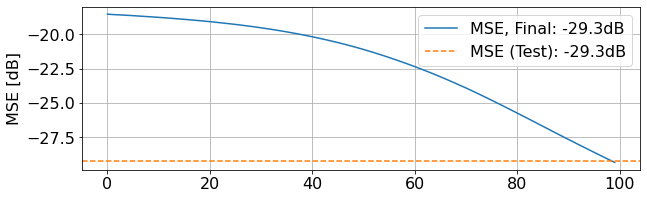

In [8]:
_, mse_test = neuralNet.evaluate(x_test_batched, y_test_batched)
mse_test_dB = np.round((10*np.log10(mse_test))*10)/10

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(10, 3))
plt.tight_layout()

finalMSE = history.history['mean_squared_error'][-1]
plt.plot(10*np.log10(history.history['mean_squared_error']), label=f'MSE, Final: {np.round((10*np.log10(finalMSE))*10)/10}dB')
plt.axhline(10*np.log10(mse_test), label=f'MSE (Test): {mse_test_dB}dB', linestyle='--', color='tab:orange')
plt.grid()
plt.legend()
plt.ylabel('MSE [dB]')
#ax[0].set_ylim((-90, 5))


print(f'Final analog MSE {10*np.log10(finalMSE)}dB')


##### Balatsoukas-Style PSD Plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


-42.56109901090725 -27.74159531671416


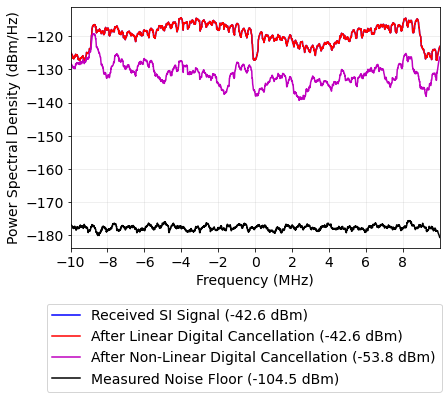


The linear SI cancellation is: 0.00 dB
The non-linear SI cancellation is: 11.26 dB
The noise floor is: -104.49 dBm
The distance from noise floor is: 50.67 dB


In [9]:
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 14}

mpl.rc('font', **font)


# Plot PSD and get signal powers
scalingConst = np.array([PSD_SCALING_CONST]) # as per balatsoukas measurements, set equally for comparability
yVarTest = np.var(y_test_batched[0, 0, CHANNEL_LEN-1:, 0])
yPred = neuralNet(x_test_batched)[0, 0, CHANNEL_LEN-1:, 0] 

if not LIN_PREPROCESSING:
    y_test_lin = 0*y_test_batched[0,0,:,0]


fig, noisePower, yTestPower, yTestLinCancPower, yTestNonLinCancPower = fd.plotPSD(y_test_batched_orig[0, 0, CHANNEL_LEN-1:, 0]/np.sqrt(scalingConst), 
                                                                        y_test_lin[(CHANNEL_LEN-1):]/np.sqrt(scalingConst), 
                                                                        yPred/(np.sqrt(scalingConst)*np.sqrt(yVarTest)), # anticipate that the function subtracts prediction from normalized SI signal
                                                                        noise/np.sqrt(scalingConst), 
                                                                        {'hSILen': CHANNEL_LEN, 'samplingFreqMHz': 20}, 
                                                                        'NN', 
                                                                        yVarTest)


#fig.savefig('/home/nknaepper/Documents/fdnn_balatsoukas/figures/comparison/data_bal_method_ours2step.eps',format='eps', bbox_inches='tight')

# Print cancellation performance
print('')
print('The linear SI cancellation is: {:.2f} dB'.format(yTestPower-yTestLinCancPower))
print('The non-linear SI cancellation is: {:.2f} dB'.format(yTestLinCancPower-yTestNonLinCancPower))
print('The noise floor is: {:.2f} dBm'.format(noisePower))
print('The distance from noise floor is: {:.2f} dB'.format(yTestNonLinCancPower-noisePower))


### Export Results

In [10]:
if EXPORT_RESULTS:
    file_name = PATH_EXPORT_RESULTS + 'data_' + DATA_TYPE + '_model_' + MODEL_TYPE + '_linSIC_' + ('yes' if LIN_PREPROCESSING else 'no') + '.pkl'
    confirm = input(f'Export as {file_name}? (yes/no)')
    if confirm == 'yes':
        with open(file_name, 'wb') as f:
            pickle.dump({'y_test': y_test_batched_orig[0, 0, CHANNEL_LEN-1:, 0], 'y_test_lin': y_test_lin[CHANNEL_LEN-1:], 'y_test_nl': yPred/np.sqrt(yVarTest), 'noise': noise, 'yVar': yVarTest, 'chanLen': CHANNEL_LEN}, f)
        print('File saved.')
    else:
        print('File not saved.')